# Advanced Time Series Forecasting for Retail: A Comparative Study

# Author: Amina Abacon

# Part 2: Feature Engineering & EDA

## Section A: Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set styles
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# STEP 1: Load Data
# ============================================================================
print("\n[1] Loading Subset Data...")
print("-" * 70)

DATA_PATH = Path('data/favorita')
PROCESSED_PATH = Path('data/processed')
OUTPUT_PATH = Path('output')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(PROCESSED_PATH / 'train_subset.csv', parse_dates=['date'])
oil_df = pd.read_csv(DATA_PATH / 'oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv(DATA_PATH / 'holidays_events.csv', parse_dates=['date'])

print(f"✓ Subset: {df.shape}")
print(f"✓ Date range: {df['date'].min().date()} to {df['date'].max().date()}")


[1] Loading Subset Data...
----------------------------------------------------------------------
✓ Subset: (109650, 6)
✓ Date range: 2015-08-16 to 2017-08-15


In [2]:
# ============================================================================
# STEP 2: Engineer Features
# ============================================================================
print("\n[2] Engineering All Features...")
print("-" * 70)

# Promotion (binary)
df['has_promotion'] = (df['onpromotion'] > 0).astype(int)

# Oil prices
oil_df = oil_df.rename(columns={'date': 'ds'})
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
oil_df['oil_ma7'] = oil_df['dcoilwtico'].rolling(window=7, min_periods=1).mean()

# Holidays (national only)
holidays_df = holidays_df.rename(columns={'date': 'ds'})
national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
national_holidays['is_holiday'] = 1
holiday_features = national_holidays.groupby('ds')['is_holiday'].max().reset_index()

# Calendar features
min_date = df['date'].min()
max_date = df['date'].max() + pd.Timedelta(days=30)
calendar_features = pd.DataFrame({'ds': pd.date_range(start=min_date, end=max_date, freq='D')})
calendar_features['dayofweek'] = calendar_features['ds'].dt.dayofweek
calendar_features['is_weekend'] = (calendar_features['dayofweek'] >= 5).astype(int)
calendar_features['month'] = calendar_features['ds'].dt.month
calendar_features['day'] = calendar_features['ds'].dt.day
calendar_features['is_month_start'] = (calendar_features['day'] <= 3).astype(int)
calendar_features['is_month_end'] = (calendar_features['day'] >= 28).astype(int)

# Merge all
df = df.rename(columns={'date': 'ds'})
df = df.merge(oil_df[['ds', 'dcoilwtico', 'oil_ma7']], on='ds', how='left')
df = df.merge(holiday_features, on='ds', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
df = df.merge(calendar_features, on='ds', how='left')
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df['oil_ma7'] = df['oil_ma7'].fillna(method='ffill').fillna(method='bfill')

# Create identifiers
df['unique_id'] = 'store_' + df['store_nbr'].astype(str) + '_' + df['family'].astype(str)
df = df.rename(columns={'sales': 'y'})

EXOG_FEATURES = ['has_promotion', 'dcoilwtico', 'oil_ma7', 'is_holiday', 
                 'is_weekend', 'month', 'dayofweek', 'is_month_start', 'is_month_end']

print(f"✓ Created {len(EXOG_FEATURES)} exogenous features")
print(f"✓ Dataset shape: {df.shape}")


[2] Engineering All Features...
----------------------------------------------------------------------
✓ Created 9 exogenous features
✓ Dataset shape: (109650, 17)


## Section B: EDA


[EDA-1] Sales Distribution Analysis...
----------------------------------------------------------------------

Overall Sales Statistics:
count    109650.000000
mean       1616.799377
std        2593.021524
min           0.000000
25%         209.730500
50%         607.000000
75%        1790.000000
max      124717.000000
Name: y, dtype: float64
✓ Saved: eda_sales_distribution.png


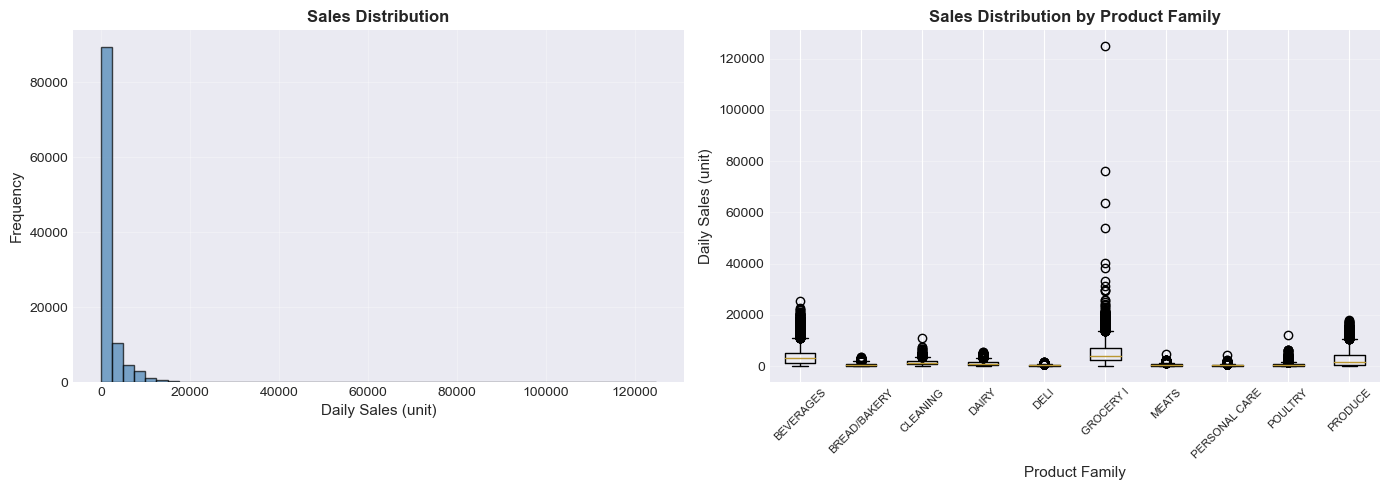

In [13]:
# ============================================================================
# EDA 1: Sales Distribution Analysis
# ============================================================================
print("\n[EDA-1] Sales Distribution Analysis...")
print("-" * 70)

print("\nOverall Sales Statistics:")
print(df['y'].describe())

# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['y'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Daily Sales (unit)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Sales Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Box plot by family
family_data = [df[df['family'] == f]['y'].values for f in df['family'].unique()]
axes[1].boxplot(family_data, labels=df['family'].unique())
axes[1].set_xlabel('Product Family', fontsize=11)
axes[1].set_ylabel('Daily Sales (unit)', fontsize=11)
axes[1].set_title('Sales Distribution by Product Family', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_sales_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_sales_distribution.png")
plt.show()


[EDA-2] Seasonality Analysis...
----------------------------------------------------------------------
✓ Saved: eda_seasonality.png


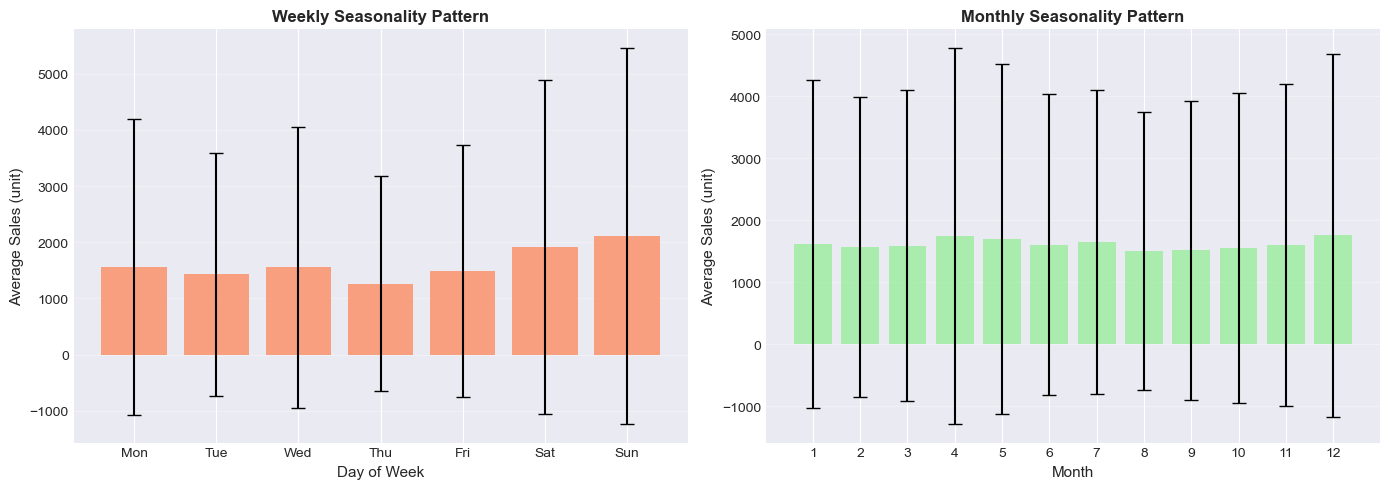


Weekly Pattern Insights:
  Best day: Sun (2110.72)
  Worst day: Thu (1260.96)


In [14]:
# ============================================================================
# EDA 2: Seasonality Analysis
# ============================================================================
print("\n[EDA-2] Seasonality Analysis...")
print("-" * 70)

# Day of week patterns
dow_sales = df.groupby('dayofweek')['y'].agg(['mean', 'std'])
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Monthly patterns
monthly_sales = df.groupby('month')['y'].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weekly seasonality
axes[0].bar(range(7), dow_sales['mean'], yerr=dow_sales['std'], 
            color='coral', alpha=0.7, capsize=5)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(dow_names)
axes[0].set_xlabel('Day of Week', fontsize=11)
axes[0].set_ylabel('Average Sales (unit)', fontsize=11)
axes[0].set_title('Weekly Seasonality Pattern', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Monthly seasonality
axes[1].bar(range(1, 13), monthly_sales['mean'], yerr=monthly_sales['std'],
            color='lightgreen', alpha=0.7, capsize=5)
axes[1].set_xticks(range(1, 13))
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Average Sales (unit)', fontsize=11)
axes[1].set_title('Monthly Seasonality Pattern', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_seasonality.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_seasonality.png")
plt.show()

print(f"\nWeekly Pattern Insights:")
best_day = dow_names[dow_sales['mean'].idxmax()]
worst_day = dow_names[dow_sales['mean'].idxmin()]
print(f"  Best day: {best_day} ({dow_sales['mean'].max():.2f})")
print(f"  Worst day: {worst_day} ({dow_sales['mean'].min():.2f})")


[EDA-3] Trend Analysis...
----------------------------------------------------------------------
✓ Saved: eda_overall_trend.png


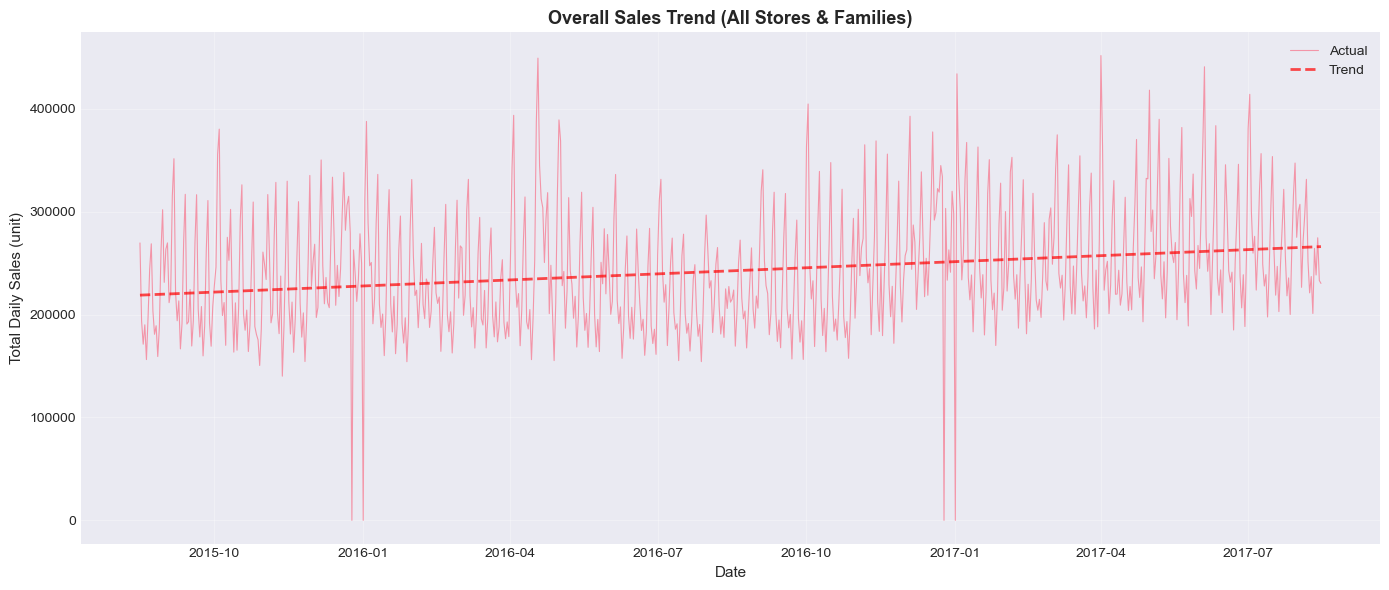

Trend: Increasing by 64.63/day


In [15]:
# ============================================================================
# EDA 3: Trend Analysis
# ============================================================================
print("\n[EDA-3] Trend Analysis...")
print("-" * 70)

# Overall trend
daily_sales = df.groupby('ds')['y'].sum()

# Calculate trend
x = np.arange(len(daily_sales))
z = np.polyfit(x, daily_sales.values, 1)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_sales.index, daily_sales.values, linewidth=0.8, alpha=0.7, label='Actual')
ax.plot(daily_sales.index, p(x), 'r--', linewidth=2, alpha=0.7, label='Trend')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Total Daily Sales (unit)', fontsize=11)
ax.set_title('Overall Sales Trend (All Stores & Families)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_overall_trend.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_overall_trend.png")
plt.show()

trend_slope = z[0]
print(f"Trend: {'Increasing' if trend_slope > 0 else 'Decreasing'} by {abs(trend_slope):.2f}/day")


[EDA-4] Promotion Impact Analysis...
----------------------------------------------------------------------

Sales by Promotion Status:
               count         mean    median          std
has_promotion                                           
0              33602   617.647132  213.0000  1363.675303
1              76048  2058.277308  909.3885  2870.023620

Promotion Lift:
  Mean: 233.2%
  Median: 326.9%
✓ Saved: eda_promotion_impact.png


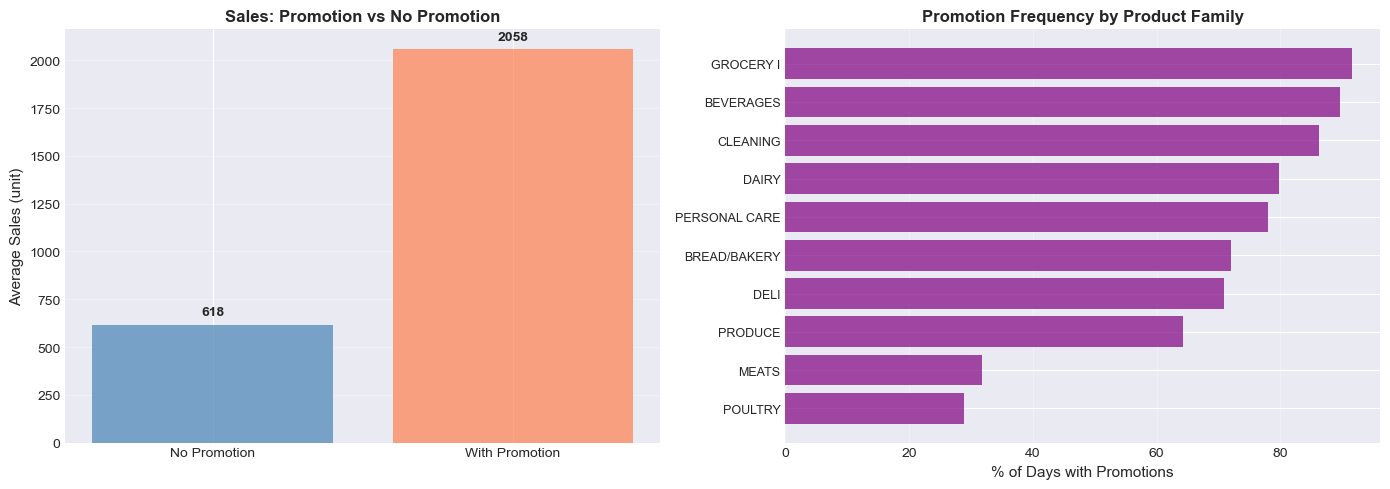

In [16]:
# ============================================================================
# EDA 4: Promotion Impact Analysis
# ============================================================================
print("\n[EDA-4] Promotion Impact Analysis...")
print("-" * 70)

promo_impact = df.groupby('has_promotion')['y'].agg(['count', 'mean', 'median', 'std'])
print("\nSales by Promotion Status:")
print(promo_impact)

if len(promo_impact) > 1:
    lift_mean = ((promo_impact.loc[1, 'mean'] - promo_impact.loc[0, 'mean']) / promo_impact.loc[0, 'mean']) * 100
    lift_median = ((promo_impact.loc[1, 'median'] - promo_impact.loc[0, 'median']) / promo_impact.loc[0, 'median']) * 100
    
    print(f"\nPromotion Lift:")
    print(f"  Mean: {lift_mean:.1f}%")
    print(f"  Median: {lift_median:.1f}%")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    promo_labels = ['No Promotion', 'With Promotion']
    axes[0].bar(promo_labels, promo_impact['mean'], color=['steelblue', 'coral'], alpha=0.7)
    axes[0].set_ylabel('Average Sales (unit)', fontsize=11)
    axes[0].set_title('Sales: Promotion vs No Promotion', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(promo_impact['mean']):
        axes[0].text(i, v + 50, f'{v:.0f}', ha='center', fontweight='bold')
    
    # Promotion frequency by family
    promo_by_family = df.groupby('family')['has_promotion'].mean() * 100
    promo_by_family = promo_by_family.sort_values(ascending=True)
    axes[1].barh(range(len(promo_by_family)), promo_by_family.values, color='purple', alpha=0.7)
    axes[1].set_yticks(range(len(promo_by_family)))
    axes[1].set_yticklabels(promo_by_family.index, fontsize=9)
    axes[1].set_xlabel('% of Days with Promotions', fontsize=11)
    axes[1].set_title('Promotion Frequency by Product Family', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'eda_promotion_impact.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: eda_promotion_impact.png")
    plt.show()

In [7]:
# ============================================================================
# EDA 5: Holiday Impact Analysis
# ============================================================================
print("\n[EDA-5] Holiday Impact Analysis...")
print("-" * 70)

holiday_impact = df.groupby('is_holiday')['y'].agg(['count', 'mean', 'std'])
print("\nSales by Holiday Status:")
print(holiday_impact)

if 1 in holiday_impact.index:
    holiday_effect = ((holiday_impact.loc[1, 'mean'] - holiday_impact.loc[0, 'mean']) / holiday_impact.loc[0, 'mean']) * 100
    print(f"Holiday Effect: {holiday_effect:+.1f}%")


[EDA-5] Holiday Impact Analysis...
----------------------------------------------------------------------

Sales by Holiday Status:
            count         mean          std
is_holiday                                 
0           98100  1606.342053  2512.672830
1           11550  1705.618730  3193.764486
Holiday Effect: +6.2%



[EDA-6] Store & Family Performance...
----------------------------------------------------------------------

Top 5 Stores by Total Sales:
store_nbr
44    3.056948e+07
45    2.749803e+07
49    2.396446e+07
51    1.596732e+07
11    1.349977e+07
Name: y, dtype: float64

Top 5 Families by Total Sales:
family
GROCERY I    5.476453e+07
BEVERAGES    4.230231e+07
PRODUCE      3.161437e+07
CLEANING     1.417574e+07
DAIRY        1.091067e+07
Name: y, dtype: float64
✓ Saved: eda_store_family_heatmap.png


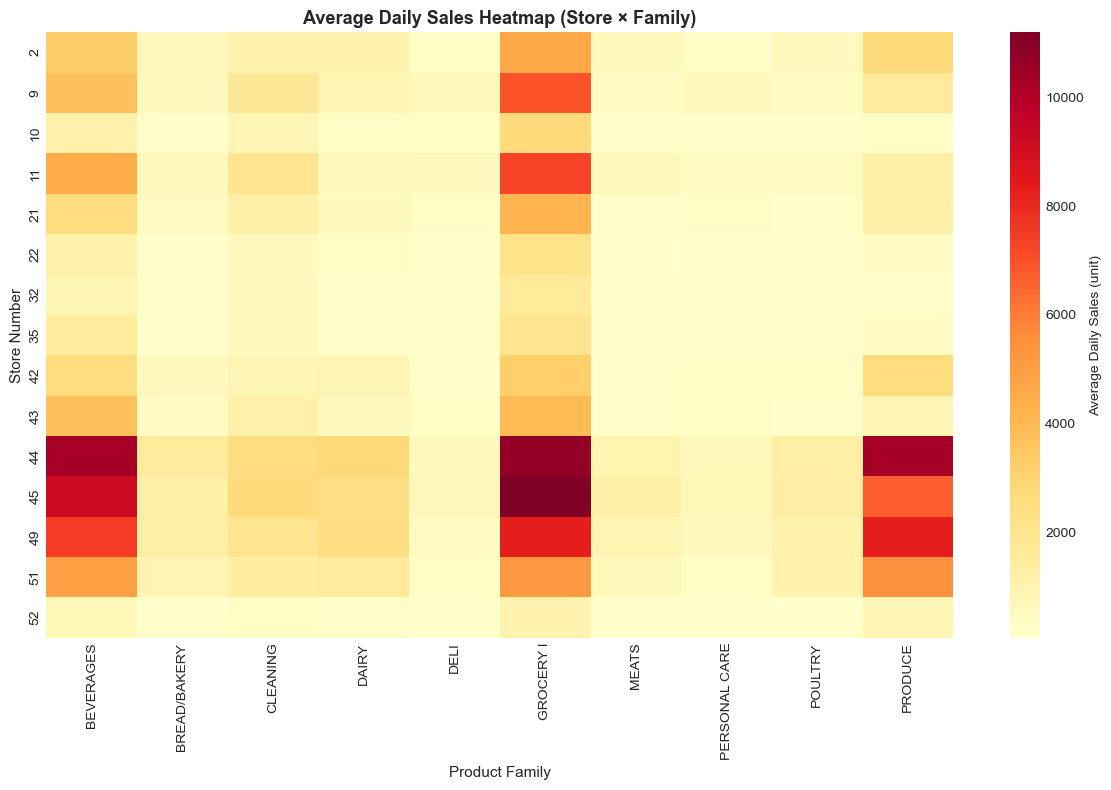

In [17]:
# ============================================================================
# EDA 6: Store & Family Comparisons
# ============================================================================
print("\n[EDA-6] Store & Family Performance...")
print("-" * 70)

# Top stores by sales
store_totals = df.groupby('store_nbr')['y'].sum().sort_values(ascending=False)
print("\nTop 5 Stores by Total Sales:")
print(store_totals.head())

# Top families by sales
family_totals = df.groupby('family')['y'].sum().sort_values(ascending=False)
print("\nTop 5 Families by Total Sales:")
print(family_totals.head())

# Heatmap of average sales
pivot_data = df.groupby(['store_nbr', 'family'])['y'].mean().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=False, fmt='.0f', cbar_kws={'label': 'Average Daily Sales (unit)'})
ax.set_xlabel('Product Family', fontsize=11)
ax.set_ylabel('Store Number', fontsize=11)
ax.set_title('Average Daily Sales Heatmap (Store × Family)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_store_family_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_store_family_heatmap.png")
plt.show()


[EDA-7] Feature Correlation Analysis (Per-Series)...
----------------------------------------------------------------------
Calculating correlations within each time series...

Per-Series Average Feature Correlations with Sales:
  is_weekend          :  0.389
  dayofweek           :  0.291
  has_promotion       :  0.225
  is_month_start      :  0.149
  dcoilwtico          :  0.097
  oil_ma7             :  0.095
  is_holiday          :  0.029
  is_month_end        : -0.010
  month               : -0.024

Global Correlations (for reference - can be misleading):
  has_promotion       :  0.256
  is_weekend          :  0.097
  dayofweek           :  0.071
  is_month_start      :  0.032
  dcoilwtico          :  0.021
  oil_ma7             :  0.021
  is_holiday          :  0.012
  month               : -0.001
  is_month_end        : -0.004

✓ Saved: eda_feature_correlations.png


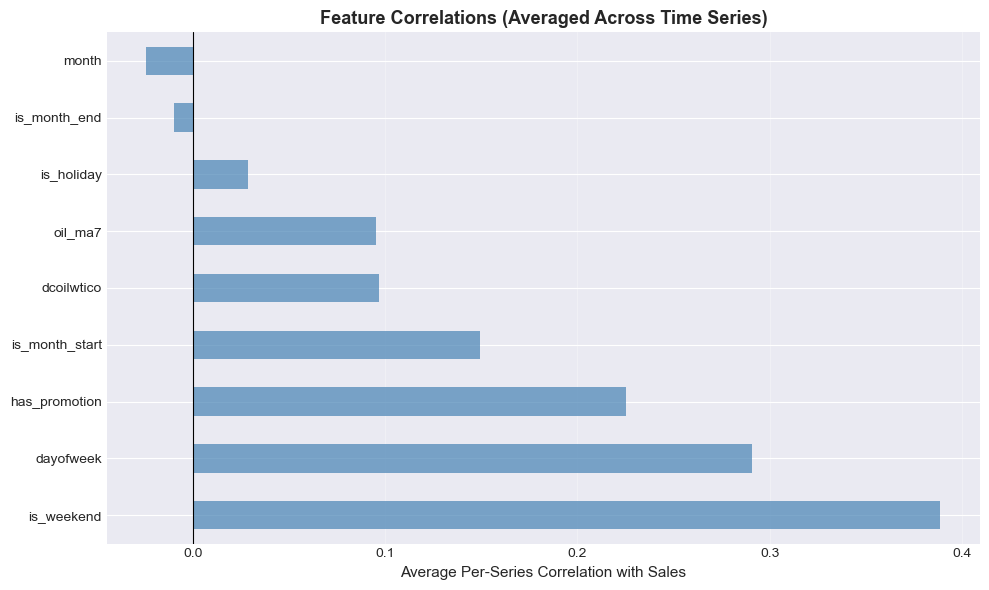

In [9]:
# ============================================================================
# EDA 7: Feature Correlations (PER-SERIES)
# ============================================================================
print("\n[EDA-7] Feature Correlation Analysis (Per-Series)...")
print("-" * 70)

print("Calculating correlations within each time series...")

# Calculate per-series correlations
series_correlations = []
for uid in df['unique_id'].unique():
    series_data = df[df['unique_id'] == uid]
    series_corr = series_data[EXOG_FEATURES + ['y']].corr()['y'].drop('y')
    series_correlations.append(series_corr)

# Average across all series
avg_correlations = pd.DataFrame(series_correlations).mean().sort_values(ascending=False)

print("\nPer-Series Average Feature Correlations with Sales:")
for feat, corr in avg_correlations.items():
    print(f"  {feat:20s}: {corr:6.3f}")

# Also show global for comparison
global_corr = df[EXOG_FEATURES + ['y']].corr()['y'].drop('y').sort_values(ascending=False)
print("\nGlobal Correlations (for reference - can be misleading):")
for feat, corr in global_corr.items():
    print(f"  {feat:20s}: {corr:6.3f}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
avg_correlations.plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
ax.set_xlabel('Average Per-Series Correlation with Sales', fontsize=11)
ax.set_title('Feature Correlations (Averaged Across Time Series)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'eda_feature_correlations.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: eda_feature_correlations.png")
plt.show()

In [10]:
# ============================================================================
# STEP: Save Everything
# ============================================================================
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save enriched dataset
df.to_csv(PROCESSED_PATH / 'train_with_features.csv', index=False)
print(f"✓ Saved: {PROCESSED_PATH / 'train_with_features.csv'}")

# Save feature config
feature_config = {
    'exogenous_features': EXOG_FEATURES,
    'num_features': len(EXOG_FEATURES),
    'per_series_correlations': avg_correlations.to_dict(),
    'global_correlations': global_corr.to_dict()
}

import json
with open(PROCESSED_PATH / 'feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f"✓ Saved: {PROCESSED_PATH / 'feature_config.json'}")


SAVING RESULTS
✓ Saved: data\processed\train_with_features.csv
✓ Saved: data\processed\feature_config.json


In [11]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 70)
print("PART 2 COMPLETE: FEATURES & EDA")
print("=" * 70)

print(f"\n Features Engineered:")
print(f"  {len(EXOG_FEATURES)} exogenous features (Kaggle-validated)")
print(f"  Most correlated: {avg_correlations.index[0]} ({avg_correlations.values[0]:.3f})")

print(f"\n EDA Completed:")
print(f"  - Sales distribution analysis")
print(f"  - Seasonality patterns (weekly, monthly)")
print(f"  - Trend analysis")
print(f"  - Promotion impact ({lift_mean:.1f}% lift)" if len(promo_impact) > 1 else "  - Promotion analysis")
print(f"  - Holiday effects")
print(f"  - Store/family comparisons")
print(f"  - Per-series feature correlations")

print(f"\n Generated Files ({7} visualizations):")
print(f"  - eda_sales_distribution.png")
print(f"  - eda_seasonality.png")
print(f"  - eda_overall_trend.png")
print(f"  - eda_promotion_impact.png")
print(f"  - eda_store_family_heatmap.png")
print(f"  - eda_feature_correlations.png")
print(f"  - train_with_features.csv")
print(f"  - feature_config.json")

print(f"\n Next Step: Part 3 - Statistical Baselines")
print("=" * 70)


PART 2 COMPLETE: FEATURES & EDA

 Features Engineered:
  9 exogenous features (Kaggle-validated)
  Most correlated: is_weekend (0.389)

 EDA Completed:
  - Sales distribution analysis
  - Seasonality patterns (weekly, monthly)
  - Trend analysis
  - Promotion impact (233.2% lift)
  - Holiday effects
  - Store/family comparisons
  - Per-series feature correlations

 Generated Files (7 visualizations):
  - eda_sales_distribution.png
  - eda_seasonality.png
  - eda_overall_trend.png
  - eda_promotion_impact.png
  - eda_store_family_heatmap.png
  - eda_feature_correlations.png
  - train_with_features.csv
  - feature_config.json

 Next Step: Part 3 - Statistical Baselines
